# Density Profile and IFT of mixture of Hexane + Ethanol

First it's needed to import the necessary modules

In [1]:
import numpy as np

from SGTPy import component, mixture, saftvrmie
from SGTPy.equilibrium import bubblePy
from SGTPy.sgt import sgt_mix, sgt_mix_beta0

import matplotlib.pyplot as plt

The binary mixture is created and then the interaction parameters is set.

In [2]:
ethanol = component('ethanol2C', ms = 1.7728, sigma = 3.5592 , eps = 224.50,
                    lambda_r = 11.319, lambda_a = 6., eAB = 3018.05, rcAB = 0.3547,
                    rdAB = 0.4, sites = [1,0,1], cii= 5.3141080872882285e-20)

hexane = component('hexane', ms = 1.96720036, sigma = 4.54762477, eps = 377.60127994, 
                   lambda_r = 18.41193194, cii = 3.581510586936205e-19)


mix = mixture(hexane, ethanol)
# fitted to experimental data
kij = 0.011818492037463553
Kij = np.array([[0, kij], [kij, 0]])
mix.kij_saft(Kij)
eos = saftvrmie(mix)

Now it is necessary to compute the equilibria pressure. This bubble point is computed with the ```bubblePy``` function. Further information about this function can be found running ```bubblePy?```.

In [3]:
# computing bubble point
T = 298.15 # K
x = np.array([0.3, 0.7])
# initial guesses for vapor compotision and pressure
y0 = 1.*x
P0 = 8000. # Pa
sol = bubblePy(y0, P0, x, T, eos, full_output=True)
sol

      T: 298.15
      P: 25589.113100628918
  error: 8.543388219095505e-12
   iter: 7
      X: array([0.3, 0.7])
     v1: 8.07509469426489e-05
  Xassl: array([0.0345788 , 0.18595376])
 state1: 'Liquid'
      Y: array([0.73246682, 0.26753318])
     v2: 0.09554139319007557
  Xassv: array([0.97728638, 0.98857796])
 state2: 'Vapor'

The results are used to compute the density vectors and the SGT is applied. First, no correction will be used ($\beta_{ij}=0$), for this case the function ```sgt_mix_beta``` with Liang's reference path method. Further information about this function can be found running ```sgt_mix_beta0?```.

In [4]:
# reading solution object
y, P = sol.Y, sol.P
vl, vv = sol.v1, sol.v2
#density vector of each phase
rhox = x/vl
rhoy = y/vv

In [5]:
# solving sgt for beta = 0
solb0 = sgt_mix_beta0(rhoy, rhox, T, P, eos, n = 300, method = 'liang', full_output = True)

C:\Users\Gusta\anaconda3\lib\site-packages\sgtpy-0.0.1-py3.8-win-amd64.egg\SGTPy\mixtures\ahs_monomer.py:105: RuntimeWarning: invalid value encountered in log
  log3 = np.log(1 - xhi3)
C:\Users\Gusta\anaconda3\lib\site-packages\sgtpy-0.0.1-py3.8-win-amd64.egg\SGTPy\mixtures\ghs_chain.py:25: RuntimeWarning: invalid value encountered in log
  k0 = -np.log(xhix_1) + (42*xhix - 39*xhix2 + 9*xhix3 - 2*xhix4)/(6*xhix_13)
C:\Users\Gusta\anaconda3\lib\site-packages\sgtpy-0.0.1-py3.8-win-amd64.egg\SGTPy\mixtures\ares.py:827: RuntimeWarning: invalid value encountered in log
  aux1 = np.log(Xass) - Xass/2 + 1/2


Finally, the $\beta_{ij}$ correction is set and SGT is applied with the function with the ```sgt_mix``` function. Further information about this function can be found running ```sgt_mix?```. 

In [6]:
bij = 0.05719272059410664
beta = np.array([[0, bij], [bij, 0]])
eos.beta_sgt(beta)

#solving BVP of SGT with 25 colocation points
solb = sgt_mix(rhoy, rhox, T, P, eos, n = 25, full_output = True)

In [7]:
print('IFT with beta = 0: ',  solb0.tension,'mN/m ')
print('IFT with beta = 0.057: ',  solb.tension,'mN/m ')

IFT with beta = 0:  16.826107984574268 mN/m 
IFT with beta = 0.057:  17.07793724356179 mN/m 


Text(0, 0.5, '$\\rho_2$ / kmol m$^{-3}$')

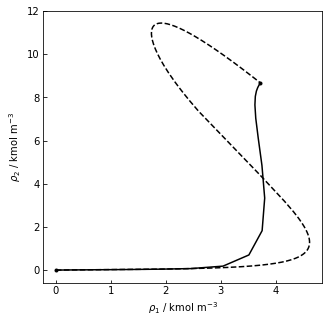

In [8]:
# density paths in kmol/m3
rho = solb0.rho / 1000
rho2 = solb.rho / 1000

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.plot(rho[0], rho[1], '--', color = 'k')
ax.plot(rho2[0], rho2[1],color = 'k')
ax.plot([rhox[0]/1000, rhoy[0]/1000], [rhox[1]/1000, rhoy[1]/1000], '.', color = 'k')

ax.tick_params(direction = 'in')
ax.set_xlabel(r'$\rho_1$ / kmol m$^{-3}$')
ax.set_ylabel(r'$\rho_2$ / kmol m$^{-3}$')